In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download alincijov/bilingual-sentence-pairs

bilingual-sentence-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!mkdir Dataset

mkdir: cannot create directory ‘Dataset’: File exists


In [4]:
cd Dataset

/content/Dataset


In [5]:
!unzip bilingual-sentence-pairs.zip

unzip:  cannot find or open bilingual-sentence-pairs.zip, bilingual-sentence-pairs.zip.zip or bilingual-sentence-pairs.zip.ZIP.


In [6]:
cd ..

/content


In [7]:
!pip install tensorflow_gpu//

ERROR: Invalid requirement: 'tensorflow_gpu//'
Hint: It looks like a path. File 'tensorflow_gpu//' does not exist.


In [8]:
import string
import re
from numpy import array, argmax, random, take
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [9]:
def read_text(filename):
        file = open(filename, mode='rt', encoding='utf-8')
        text = file.read()
        file.close()
        return text

In [10]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [11]:
cd content

[Errno 2] No such file or directory: 'content'
/content


In [12]:
data = read_text("deu.txt")

In [13]:
type(data)

str

In [14]:
data[0:100]

'Go.\tGeh.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)\nHi.\tHallo!\tCC'

In [15]:
data

In [1]:
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

NameError: ignored

In [ ]:
deu_eng[0:10]

In [ ]:
type(deu_eng)

## 구두점 제거 PreProcessing

In [ ]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [ ]:
deu_eng[0:10]

## 같은 lower로

In [ ]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

## 문장당 길이를 check # 단어 수

In [ ]:
eng_l = []
deu_l = []

for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

In [ ]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Korea Vocabulary Size: %d' % deu_vocab_size)

In [ ]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split
## korea 문장을 train,test set으로 분할
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [ ]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

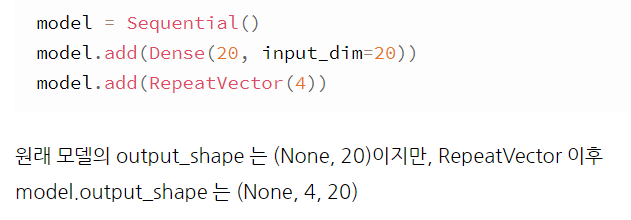

In [ ]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    # in vocab : 문장의 최대 길이 , out_vocab : 문장 output 최대 길이
    model = Sequential()
    ## units : 임베딩 레이어에 얼마나 많은 뉴런이 있는지.!
    ## 즉 mask_zero 는 invocab의 길이가 같지 않으면 문장끝에 0 을추가한다.
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    ## 동일한 수의 LSTM 추가
    model.add(LSTM(units))
    ## repeatVector -> 입력을 여러번 반복
    ## out_timestpes : out_timestpe만큼 반복
    model.add(RepeatVector(out_timesteps))
    ## LSTM # return sequence True => 모델에게 값 전달
    model.add(LSTM(units, return_sequences=True))
    ## out_vocab vector에서 softmax로 각각의 확률값으로 ouput 값 나오는
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
model.summary()

## Cost Function
### RSM
### loss 는 softmax이므로 sparse_categorical_crossentropy

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

## model Checkpoint 설정 및 학습

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h5')

In [ ]:
testX1 = testX[0:100]

In [ ]:
testX1[0]

In [ ]:
preds = model.predict(testX1.reshape((testX1.shape[0],testX1.shape[1])))
preds=np.argmax(preds,axis=1)

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [ ]:
test[0]

In [ ]:
preds_text[0]